Code from: https://www.kaggle.com/philschmidt/cervix-eda-model-selection

Import libraries and packages:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread, imshow
import cv2 # first I needed to run following command: sudo pip3 install opencv-python

%matplotlib inline
import plotly.offline as py # first I needed to run following command: pip install plotly
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from subprocess import check_output
from glob import glob
import os

Print files in current directory (gives you list of labels, since the images are organized by label directory!):

In [ ]:
print(check_output(["ls", "sample_train_cervix_shapes"]).decode("utf8"))

Create dataframe where you have each image path, file type and label:

In [ ]:
basepath = 'sample_train_cervix_shapes/'

all_cervix_images = []

for path in sorted(glob(basepath + "*")): # iterate through each directory (ie each type)
    cervix_type = path.split("/")[-1] # gives you the type (ie directory) of current instance
    cervix_images = sorted(glob(basepath + cervix_type + "/*")) # gives you all images in current directory,
        # in the following format: sample_train_cervix_shapes/Type1/image_number.jpg
    all_cervix_images = all_cervix_images + cervix_images # list of all of the images in same format as previous!
    
all_cervix_images = pd.DataFrame({'imagepath': all_cervix_images})
all_cervix_images['filetype'] = all_cervix_images.apply(lambda row: row.imagepath.split(".")[-1], axis=1)
all_cervix_images['type'] = all_cervix_images.apply(lambda row: row.imagepath.split("/")[-2], axis=1)
all_cervix_images.head()

Count how many images per label:

In [ ]:
print('We have a total of {} images in the whole dataset'.format(all_cervix_images.shape[0]))
type_aggregation = all_cervix_images.groupby(['type', 'filetype']).agg('count')
type_aggregation_p = type_aggregation.apply(lambda row: 1.0*row['imagepath']/all_cervix_images.shape[0], axis=1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

type_aggregation.plot.barh(ax=axes[0])
axes[0].set_xlabel("image count")
type_aggregation_p.plot.barh(ax=axes[1])
axes[1].set_xlabel("training size fraction")

Method 1 for visualizing images:

In [ ]:
fig = plt.figure(figsize=(12,8))

### generic method ###
plt.imshow(plt.imread('sample_train_cervix_shapes/Type2/31.jpg'))

### visualize one image per cervix type ###
fig = plt.figure(figsize=(12,8))
i = 1
for t in all_cervix_images['type'].unique():
    ax = fig.add_subplot(1,3,i)
    i+=1
    f = all_cervix_images[all_cervix_images['type'] == t]['imagepath'].values[0]
    plt.imshow(plt.imread(f))
    plt.title('sample for cervix {}'.format(t))

Get the distribution of image dimensions by type, via df and barplots (note: all images have 3 channels since tehy are in RGB): 

In [ ]:
from collections import defaultdict

images = defaultdict(list)

for t in all_cervix_images['type'].unique():
    sample_counter = 0
    for _, row in all_cervix_images[all_cervix_images['type'] == t].iterrows():
        #print('reading image {}'.format(row.imagepath))
        try:
            img = imread(row.imagepath)
            sample_counter +=1
            images[t].append(img)
        except:
            print('image read failed for {}'.format(row.imagepath))
        if sample_counter > 35:
            break
dfs = []
for t in all_cervix_images['type'].unique():
    t_ = pd.DataFrame(
        {
            'nrows': list(map(lambda i: i.shape[0], images[t])),
            'ncols': list(map(lambda i: i.shape[1], images[t])),
            'nchans': list(map(lambda i: i.shape[2], images[t])),
            'type': t
        }
    )
    dfs.append(t_)

shapes_df = pd.concat(dfs, axis=0)
shapes_df_grouped = shapes_df.groupby(by=['nchans', 'ncols', 'nrows', 'type']).size().reset_index().sort_values(['type', 0], ascending=False)
# get the .csv file of size_by_type:
# shapes_df_grouped.to_csv("size_by_type_distribution.csv")

shapes_df_grouped['size_with_type'] = shapes_df_grouped.apply(lambda row: '{}-{}-{}'.format(row.ncols, row.nrows, row.type), axis=1)
shapes_df_grouped = shapes_df_grouped.set_index(shapes_df_grouped['size_with_type'].values)
shapes_df_grouped['count'] = shapes_df_grouped[[0]]

plt.figure(figsize=(10,8))
#shapes_df_grouped['count'].plot.barh(figsize=(10,8))
sns.barplot(x="count", y="size_with_type", data=shapes_df_grouped)

Function that returns the file path of the image in the format of "sample_train_cervix_shapes/Type{1, 2, 3}/???.jpg" (https://www.kaggle.com/vfdev5/data-exploration-1/notebook):

In [ ]:
def get_filename(image_id, image_type):
    """
    Method to get image file path from its id and type   
    """
    if image_type == "Type1" or \
        image_type == "Type2" or \
        image_type == "Type3":
        data_path = os.path.join(basepath, image_type)
    else:
        raise Exception("Image type '%s' is not recognized" % image_type)
    '''
    elif image_type == "Test":
        data_path = TEST_DATA
    elif image_type == "AType_1" or \
          image_type == "AType_2" or \
          image_type == "AType_3":
        data_path = os.path.join(ADDITIONAL_DATA, image_type[1:])
    '''   
    ext = 'jpg'
    return os.path.join(data_path, "{}.{}".format(image_id, ext))

Function that returns the a tensor of the rgb values of the image; allows you to modify tensor values (https://www.kaggle.com/vfdev5/data-exploration-1/notebook):

In [ ]:
def get_image_data(image_id, image_type):
    """
    Method to get image data as np.array specifying image id and type
    """
    fname = get_filename(image_id, image_type)
        # fname = sample_train_cervix_shapes/Type{1, 2, 3}/???.jpg
    img = cv2.imread(fname)
        # cv2.imread(sample_train_cervix_shapes/Type{1, 2, 3}/???.jpg)
    assert img is not None, "Failed to read image : %s, %s" % (image_id, image_type)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
get_image_data("191","Type1")

Function that displays the image (figure) and allows you to define the size of the output figure

In [ ]:
def plt_st(l1,l2):
    plt.figure(figsize=(l1,l2))

Function that allows you to optionally **resize, normalize and grayscale** the image (https://www.kaggle.com/philschmidt/cervix-eda-model-selection#Image-clustering-with-TSNE-embedding): 

In [ ]:
def transform_image(img, rescaled_dim_x, rescaled_dim_y, to_gray=False, normalized=False):
    resized = cv2.resize(img, dsize=(rescaled_dim_x, rescaled_dim_y))

    if to_gray:
        resized = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY).astype('float')
    '''
    else:
        resized = resized.astype('float')
        
    if normalized:
        normalized = cv2.normalize(resized, None, 0.0, 1.0, cv2.NORM_MINMAX)
        timg = normalized.reshape(1, np.prod(normalized.shape))
        # return timg/np.linalg.norm(timg)
    '''
    return resized
def mask_black_bkgd(img):
    #Invert the image to be white on black for compatibility with findContours function.

    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #Binarize the image and call it thresh.
    ret, thresh = cv2.threshold(imgray, 127, 255, cv2.THRESH_BINARY)

    #Find all the contours in thresh. In your case the 3 and the additional strike
    im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    #Calculate bounding rectangles for each contour.
    rects = [cv2.boundingRect(cnt) for cnt in contours]

    #Calculate the combined bounding rectangle points.
    top_x = min([x for (x, y, w, h) in rects])
    top_y = min([y for (x, y, w, h) in rects])
    bottom_x = max([x+w for (x, y, w, h) in rects])
    bottom_y = max([y+h for (x, y, w, h) in rects])

    #Draw the rectangle on the image
    #out = cv2.rectangle(img, (top_x, top_y), (bottom_x, bottom_y), (0, 255, 0), 2)
    crop = img[top_y:bottom_y,top_x:bottom_x]
    return crop #thresh

Experimenting with getting images:

In [ ]:
'''
img = get_image_data(191, "Type1") 
plt_st(10, 10)
plt.imshow(img)
plt.title("Original image")

img = cv2.resize(img, dsize=(256,256))
plt_st(10, 10)
plt.imshow(img)
plt.title("Resized image")

img = transform_image(img,256,256,to_gray=True)
plt_st(10, 10)
plt.imshow(img)
plt.title("Resized image")
'''
img = get_image_data(191, "Type1") 
#img = mask_black_bkgd(img)
#plt.imshow(img)
#plt.title("black background?")

#imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #Binarize the image and call it thresh.
#ret, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
LUV = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
edges = cv2.Canny(LUV, 10, 100)
plt.imshow(thresh)
    #Find all the contours in thresh. In your case the 3 and the additional strike
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#contours, hierarchy = cv2.findContours(edges,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#     #Calculate bounding rectangles for each contour.
#     rects = [cv2.boundingRect(cnt) for cnt in contours]

#     #Calculate the combined bounding rectangle points.
#     top_x = min([x for (x, y, w, h) in rects])
#     top_y = min([y for (x, y, w, h) in rects])
#     bottom_x = max([x+w for (x, y, w, h) in rects])
#     bottom_y = max([y+h for (x, y, w, h) in rects])

#     #Draw the rectangle on the image
#     #out = cv2.rectangle(img, (top_x, top_y), (bottom_x, bottom_y), (0, 255, 0), 2)
#     crop = img[top_y:bottom_y,top_x:bottom_x]
#     return crop #thresh
'''
img = cv2.putText(img, (5,img.shape[0] - 5), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (4, 4, 5), thickness=3)
plt_st(10, 10)
plt.imshow(img)
plt.title("Labeled image")
'''

In [ ]:
from __future__ import print_function
import cv2 as cv
import numpy as np
import argparse
import random as rng
rng.seed(12345)
def thresh_callback(val):
    threshold = val
    # Detect edges using Canny
    canny_output = cv.Canny(src_gray, threshold, threshold * 2)
    # Find contours
    contours, hierarchy = cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    # Draw contours
    drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)
    for i in range(len(contours)):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        cv.drawContours(drawing, contours, i, color, 2, cv.LINE_8, hierarchy, 0)
    # Show in a window
    cv.imshow('Contours', drawing)
# Load source image
img = get_image_data(191, "Type1") 
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img = cv.blur(img, (3,3))

# Create Window
source_window = 'Source'
cv.namedWindow(source_window)
cv.imshow(source_window, img)

max_thresh = 255
thresh = 100 # initial threshold
cv.createTrackbar('Canny Thresh:', source_window, thresh, max_thresh, thresh_callback)
thresh_callback(thresh)
cv.waitKey()

In [32]:
def sieve(image, size):
    """
    Filter removes small objects of 'size' from binary image
    Input image should be a single band image of type np.uint8
    Idea : use Opencv findContours
    """
    sqLimit = size**2
    linLimit = size*4
    outImage = image.copy()
    image, contours, hierarchy = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if len(hierarchy) > 0:
        hierarchy = hierarchy[0]
        index = 0
        while index >= 0:
            contour = contours[index]
            p = cv2.arcLength(contour, True)
            s = cv2.contourArea(contour)
            r = cv2.boundingRect(contour)
            if s <= sqLimit and p <= linLimit:
                outImage[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = 0
            index = hierarchy[index][0]
    else:
        pass
        # print("No contours found")
    return outImage

img = get_image_data(191, "Type1") 
img = sieve(img,7)
plt.imshow(img)

# in HSV :
skin_range_1_min = np.array([120, 0, 0], dtype=np.uint8)
skin_range_1_max = np.array([255, 255, 255], dtype=np.uint8)

skin_range_2_min = np.array([0, 0, 0], dtype=np.uint8)
skin_range_2_max = np.array([45, 255, 255], dtype=np.uint8)

skin_kernel_size = 7
skin_sieve_min_size = 5
'''
def detect_skin(image):
    proc = cv2.medianBlur(image, 7)
    ### Detect skin
    image_hsv = cv2.cvtColor(proc, cv2.COLOR_RGB2HSV)
    skin_like_mask = cv2.inRange(image_hsv, skin_range_1_min, skin_range_1_max)
    skin_like_mask_2 = cv2.inRange(image_hsv, skin_range_2_min, skin_range_2_max)
    skin_like_mask = cv2.bitwise_or(skin_like_mask, skin_like_mask_2)    
    # Filter the skin mask :
    skin_mask = sieve(skin_like_mask, skin_sieve_min_size)
    kernel = np.ones((skin_kernel_size, skin_kernel_size), dtype=np.int8)
    skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_CLOSE, kernel)    
    # Apply skin mask
    skin_segm_rgb = cv2.bitwise_and(image, image, mask=skin_mask)
    return skin_segm_rgb
for image in [img_1, img_2, img_3, img_4, img_5]:       
    image = cv2.resize(image, dsize=(512, 512))
    skin_segm_rgb = detect_skin(image)
    plt_st(12, 4)
    plt.subplot(121)
    plt.title("Original image")    
    plt.imshow(image)
    plt.subplot(122)
    plt.title("Skin segmentation")
    plt.imshow(skin_segm_rgb)
'''

error: OpenCV(4.3.0) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


'\n    img = cv2.imread(fname)\n    assert img is not None, "Failed to read image : %s, %s" % (image_id, image_type)\n    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\nimg3 = get_image_data(191, "Type1") \nimg3= transform_image(img2, 256, 256,normalized=True)\nplt_st(10, 10)\nplt.imshow(img3)\nplt.title("Resized and normalized")\n\nimg4 = get_image_data(191, "Type1") \nimg4= transform_image(img2, 256, 256,to_gray=True)\nplt_st(10, 10)\nplt.imshow(img4)\nplt.title("Resized and grayscaled")\n\nimg5 = get_image_data(191, "Type1") \nimg5= transform_image(img2, 256, 256,to_gray=True,normalized=True)\nplt_st(10, 10)\nplt.imshow(img5)\nplt.title("Resized, grayscaled and normalized")\n'

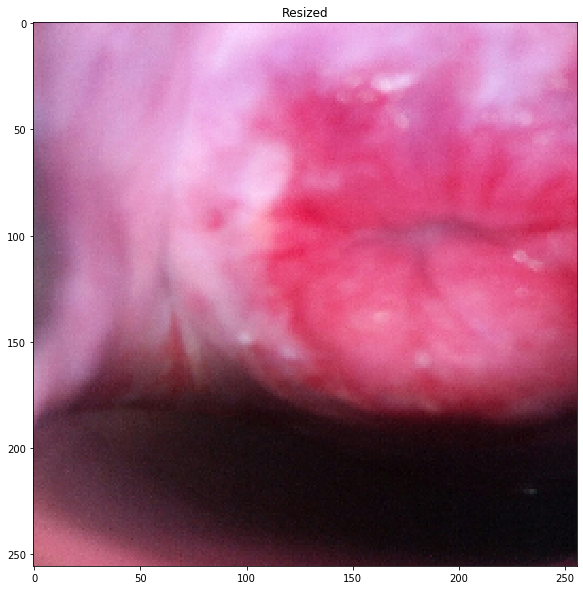

In [27]:
img2 = get_image_data(191, "Type1") 
img2= transform_image(img2, 256, 256)
plt_st(10, 10)
plt.imshow(img2)
plt.title("Resized")
'''
    img = cv2.imread(fname)
    assert img is not None, "Failed to read image : %s, %s" % (image_id, image_type)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img3 = get_image_data(191, "Type1") 
img3= transform_image(img2, 256, 256,normalized=True)
plt_st(10, 10)
plt.imshow(img3)
plt.title("Resized and normalized")

img4 = get_image_data(191, "Type1") 
img4= transform_image(img2, 256, 256,to_gray=True)
plt_st(10, 10)
plt.imshow(img4)
plt.title("Resized and grayscaled")

img5 = get_image_data(191, "Type1") 
img5= transform_image(img2, 256, 256,to_gray=True,normalized=True)
plt_st(10, 10)
plt.imshow(img5)
plt.title("Resized, grayscaled and normalized")
'''

Script that creates an array with all the tensors, where array[0] = type 1 tensors, ..., array[2] = type 3 tensors.

In [39]:
type_1_files = glob(os.path.join(basepath, "Type1", "*.jpg"))
type_1_ids = np.array([s[len(os.path.join(basepath, "Type1"))+1:-4] for s in type_1_files])
type_2_files = glob(os.path.join(basepath, "Type2", "*.jpg"))
type_2_ids = np.array([s[len(os.path.join(basepath, "Type2"))+1:-4] for s in type_2_files])
type_3_files = glob(os.path.join(basepath, "Type3", "*.jpg"))
type_3_ids = np.array([s[len(os.path.join(basepath, "Type3"))+1:-4] for s in type_3_files])

tile_size = (256, 256)
n = 15

complete_images = []
for k, type_ids in enumerate([type_1_ids, type_2_ids, type_3_ids]):
    m = int(np.ceil(len(type_ids) * 1.0 / n))
    complete_image = np.zeros((m*(tile_size[0]+2), n*(tile_size[1]+2), 3), dtype=np.uint8)
        # np.zeros(12, 105, 3)
    train_ids = sorted(type_ids)
    counter = 0  
    for i in range(m):
        ys = i*(tile_size[1] + 2)
        ye = ys + tile_size[1]
        for j in range(n):
            xs = j*(tile_size[0] + 2)
            xe = xs + tile_size[0]
            if counter == len(train_ids):
                break
            image_id = train_ids[counter]; counter+=1
            img = get_image_data(image_id, 'Type%i' % (k+1))
            img = cv2.resize(img, dsize=tile_size)
            img = cv2.putText(img, image_id, (5,img.shape[0] - 5), cv2.FONT_HERSHEY_SIMPLEX, 2.0,
                              (255, 255, 255) # text colour!
                              , thickness=3)
            complete_image[ys:ye, xs:xe, :] = img[:,:,:]
        if counter == len(train_ids):
            break
    complete_images.append(complete_image) 

In [49]:
print("type(complete_images): ",type(complete_images))
print("type(complete_images[0]): ",type(complete_images[0]))
print("len(complete_images): ",len(complete_images))
print("len(complete_images[0]): ",len(complete_images[0][0][0]))

type(complete_images):  <class 'list'>
type(complete_images[0]):  <class 'numpy.ndarray'>
len(complete_images):  3
len(complete_images[0]):  3


Display all train images across labels, from this notebook: https://www.kaggle.com/vfdev5/data-exploration-1

In [ ]:
plt_st(20, 20)
plt.imshow(complete_images[0])
plt.title("Training dataset of type 1")

In [ ]:
plt_st(20, 20)
plt.imshow(complete_images[1])
plt.title("Training dataset of type 2")

In [ ]:
plt_st(20, 20)
plt.imshow(complete_images[2])
plt.title("Training dataset of type 3")

Test CNN to figure out correct input format (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html): 

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')